Objective: To implement, evaluate, and compare three tree-based machine learning methods on the engineered features dataset. The models are:

Decision Tree

Random Forest

Gradient Boosting

outline a formal evaluation framework for model selection.

In [10]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Models
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgbm  # <-- ADD THIS LINE

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set styles and random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option('display.max_columns', 50)

print("Libraries imported successfully.")

Libraries imported successfully.


# Load and Prepare Data

In [2]:
# Load the pre-engineered dataset
try:
    df = pd.read_csv("public_cases_derived_features.csv")
    print(f"Successfully loaded {len(df)} records with {len(df.columns)-1} features.")
except FileNotFoundError:
    print("Error: 'public_cases_derived_features.csv' not found.")
    # Handle error or stop execution
    
# Define our target variable
TARGET = 'expected_output'

# Define our feature list (all columns except the target)
FEATURES = [col for col in df.columns if col != TARGET]

# Create our main X and y data
X = df[FEATURES]
y = df[TARGET]

display(df.head())

Successfully loaded 1000 records with 27 features.


,trip_duration_days,miles_traveled,total_receipts_amount,miles_per_day,receipts_per_day,log_receipts,sqrt_miles,is_5day,is_long_trip,is_sweet_spot,is_receipts_over_800,is_receipts_under_50,is_rpd_under_20,is_efficient_miles,is_modest_short,is_modest_med,is_modest_long,is_vacation_penalty,is_miles_tier1,is_miles_tier2,is_cents_49,is_cents_99,days_x_miles,days_x_receipts,miles_x_receipts,miles_sq,receipts_sq,expected_output
0,3,93.0,1.42,30.999990,0.473333,0.883768,9.643651,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,279.0,4.26,132.06,8649.0,2.0164,364.51
1,1,55.0,3.60,54.999945,3.599996,1.526056,7.416198,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,55.0,3.60,198.00,3025.0,12.9600,126.06
2,1,47.0,17.97,46.999953,17.969982,2.942859,6.855655,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,47.0,17.97,844.59,2209.0,322.9209,128.91
3,2,13.0,4.67,6.499997,2.334999,1.735189,3.605551,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,26.0,9.34,60.71,169.0,21.8089,203.52
4,3,88.0,5.78,29.333324,1.926666,1.913977,9.380832,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,264.0,17.34,508.64,7744.0,33.4084,380.37


# Data Splitting

In [3]:
# Create a 75/25 train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

print(f"Training samples:   {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples:   750
Validation samples: 250


# Custom Evaluation Function

helper function that calculates all the metrics from the challenge eval.sh script: Exact Matches, Close Matches, MAE, and the final Score.

In [4]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculates and prints the full suite of evaluation metrics
    in the challenge-specified format.
    """
    # Ensure inputs are numpy arrays for comparison
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate metrics
    diffs = np.abs(y_pred - y_true)
    total_cases = len(y_true)
    
    exact_matches = int(np.sum(diffs < 0.01))
    close_matches = int(np.sum(diffs < 1.00))
    mae = np.mean(diffs)
    
    # Calculate score
    score = (mae * 100) + (total_cases - exact_matches) * 0.1
    
    # Print the report
    print("\n--- Model Report ---")
    print(f"[{model_name}] Total={total_cases} | Exact={exact_matches} | Close(< $1.00)={close_matches} | MAE=${mae:.2f} | Score={score:.2f}")
    
    return mae, score

print("Evaluation helper function `evaluate_model` defined.")

Evaluation helper function `evaluate_model` defined.


# Decision Tree Model

In [5]:
# 1. Initialize the model
# We set max_depth to 6 to keep the tree interpretable
dt_model = DecisionTreeRegressor(
    max_depth=6, 
    random_state=RANDOM_STATE
)

# 2. Fit the model on training data
dt_model.fit(X_train, y_train)

# 3. Make predictions on validation data
y_pred_dt = dt_model.predict(X_val)

# 4. Evaluate the model
evaluate_model(y_val, y_pred_dt, "Decision Tree (Depth=6)")


--- Model Report ---
[Decision Tree (Depth=6)] Total=250 | Exact=1 | Close(< $1.00)=2 | MAE=$87.48 | Score=8773.35


(87.48445123452933, 8773.345123452933)

## Decision Tree - Interpretability Analysis

--- Decision Tree Rule Visualization ---


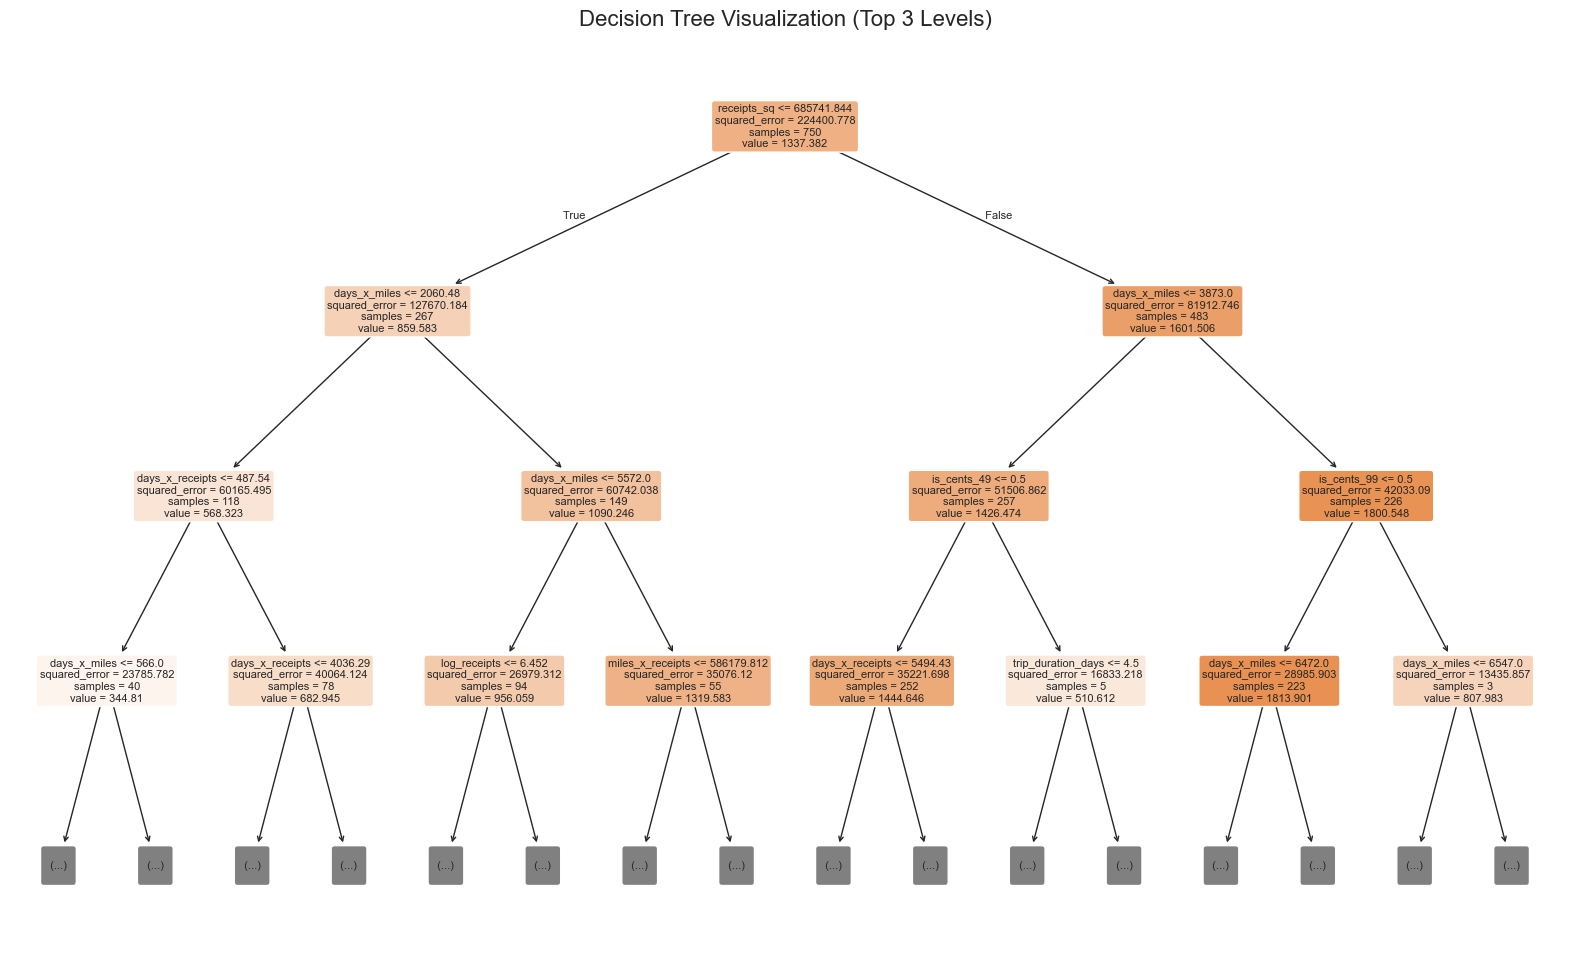

In [6]:
print("--- Decision Tree Rule Visualization ---")

plt.figure(figsize=(20, 12))
plot_tree(
    dt_model, 
    feature_names=FEATURES,
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=3  # Only show top 3 levels for readability
)
plt.title("Decision Tree Visualization (Top 3 Levels)", fontsize=16)
plt.show()

# Random Forest with feature importance

## Random Forest - Implementation

In [7]:
# 1. Initialize the model
# n_estimators=100 means it will build 100 different trees
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1  # Use all available CPU cores
)

# 2. Fit the model
rf_model.fit(X_train, y_train)

# 3. Predict
y_pred_rf = rf_model.predict(X_val)

# 4. Evaluate
evaluate_model(y_val, y_pred_rf, "Random Forest (100 Trees)")


--- Model Report ---
[Random Forest (100 Trees)] Total=250 | Exact=0 | Close(< $1.00)=4 | MAE=$64.21 | Score=6446.37


(64.21374039999996, 6446.374039999996)

## Random Forest - Feature Importance Analysis

--- Random Forest Feature Importances ---


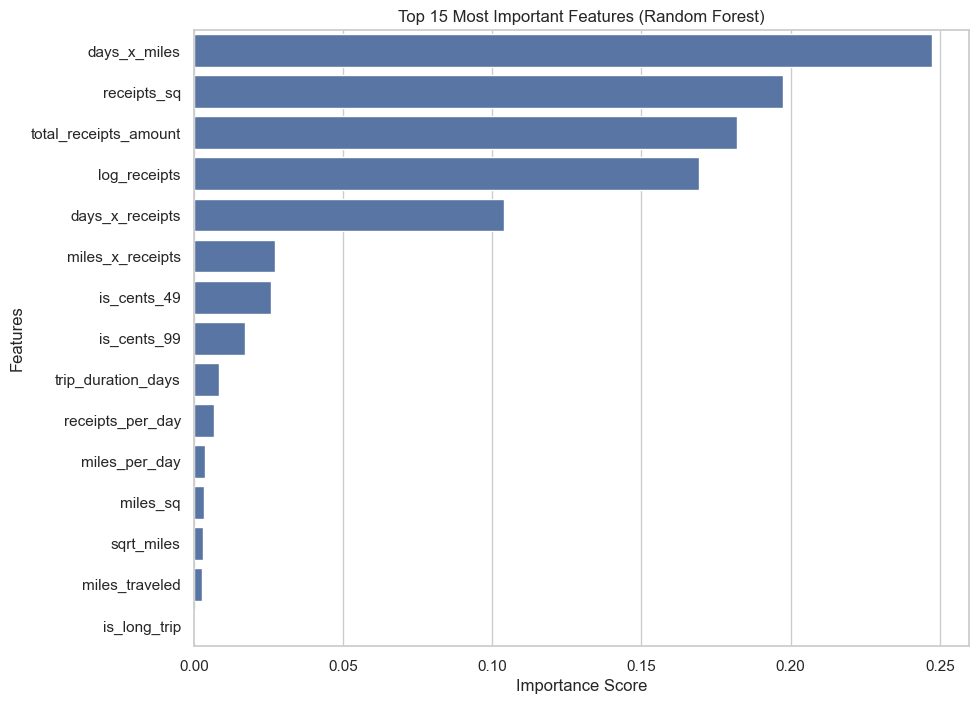

Top 10 features:


days_x_miles             0.247420
receipts_sq              0.197360
total_receipts_amount    0.181999
log_receipts             0.169211
days_x_receipts          0.103762
miles_x_receipts         0.027226
is_cents_49              0.025920
is_cents_99              0.017238
trip_duration_days       0.008461
receipts_per_day         0.006598
dtype: float64

In [8]:
print("--- Random Forest Feature Importances ---")

# Create a Series to hold the feature importances
importances = pd.Series(
    rf_model.feature_importances_, 
    index=FEATURES
).sort_values(ascending=False)

# Plot the top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(
    x=importances.head(15), 
    y=importances.head(15).index
)
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Display the top 10 as text
print("Top 10 features:")
display(importances.head(10))

# Gradient Boosting

## XGBoost

In [11]:
# --- 3a. XGBoost ---

# 1. Initialize
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=RANDOM_STATE
)

# 2. Fit
print("Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# 3. Predict
y_pred_xgb = xgb_model.predict(X_val)

# 4. Evaluate
print(f"XGBoost best iteration: {xgb_model.best_iteration}")
evaluate_model(y_val, y_pred_xgb, "XGBoost")

Training XGBoost...
XGBoost best iteration: 871

--- Model Report ---
[XGBoost] Total=250 | Exact=0 | Close(< $1.00)=4 | MAE=$59.20 | Score=5945.11


(59.201096652832035, 5945.109665283204)

## LightGBM

In [12]:
# --- 3b. LightGBM ---

# 1. Initialize
lgbm_model = lgbm.LGBMRegressor(  # Use lgbm alias
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

# 2. Fit
print("\nTraining LightGBM...")
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        # Use the correct callback method
        lgbm.early_stopping(50, verbose=False) 
    ]
)

# 3. Predict
y_pred_lgbm = lgbm_model.predict(X_val)

# 4. Evaluate
print(f"LightGBM best iteration: {lgbm_model.best_iteration_}")
evaluate_model(y_val, y_pred_lgbm, "LightGBM")


Training LightGBM...
LightGBM best iteration: 534

--- Model Report ---
[LightGBM] Total=250 | Exact=0 | Close(< $1.00)=2 | MAE=$70.04 | Score=7029.28


(70.04283906339563, 7029.283906339563)

In [13]:
def get_model_stats(y_true, y_pred, model_name):
    """
    Calculates all four key metrics for a given model.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    diffs = np.abs(y_pred - y_true)
    total_cases = len(y_true)
    
    # Calculate metrics
    exact_matches = int(np.sum(diffs < 0.01))
    close_matches = int(np.sum(diffs < 1.00))
    mae = np.mean(diffs)
    
    # Calculate score (lower is better)
    score = (mae * 100) + (total_cases - exact_matches) * 0.1
    
    return {
        "Model": model_name,
        "MAE": mae,
        "Score": score,
        "Exact Matches (±$0.01)": exact_matches,
        "Close Matches (±$1.00)": close_matches
    }

# --- Collect Results from all models ---
results_list = []

# 1. Decision Tree
results_list.append(get_model_stats(y_val, y_pred_dt, "1. Decision Tree"))

# 2. Random Forest
results_list.append(get_model_stats(y_val, y_pred_rf, "2. Random Forest"))

# 3. XGBoost
results_list.append(get_model_stats(y_val, y_pred_xgb, "3. XGBoost"))

# 4. LightGBM
results_list.append(get_model_stats(y_val, y_pred_lgbm, "4. LightGBM"))

# --- Create and Display Comparison Table ---
df_comparison = pd.DataFrame(results_list)
df_comparison = df_comparison.set_index('Model')

# Sort by the final Score (lower is better)
df_comparison = df_comparison.sort_values(by='Score', ascending=True)

print("--- Final Model Comparison (on 25% Validation Set) ---")
display(df_comparison.style.format({
    'MAE': '${:,.2f}',
    'Score': '{:,.2f}',
    'Exact Matches (±$0.01)': '{:,.0f}',
    'Close Matches (±$1.00)': '{:,.0f}'
}))

--- Final Model Comparison (on 25% Validation Set) ---


,MAE,Score,Exact Matches (±$0.01),Close Matches (±$1.00)
Model,,,,
3. XGBoost,$59.20,"5,945.11",0,4
2. Random Forest,$64.21,"6,446.37",0,4
4. LightGBM,$70.04,"7,029.28",0,2
1. Decision Tree,$87.48,"8,773.35",1,2
